In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path  = '/content/drive/MyDrive/Projects/HDA Proj/mini_dataset'

In [4]:
class OCTDataLoader:
    def __init__(self, data_dir, img_size=(224, 224), batch_size=48):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.test_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def get_loaders(self):
        try:
            train_dataset = datasets.ImageFolder(f'{self.data_dir}/train', transform=self.train_transform)
            test_dataset = datasets.ImageFolder(f'{self.data_dir}/test', transform=self.test_transform)
        except FileNotFoundError as e:
            print("Error: One of the required directories or files is missing.")
            raise e

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

        return train_loader, test_loader

In [5]:
data_loader = OCTDataLoader(data_dir=path, img_size=(224, 224), batch_size=96)
train_loader, test_loader = data_loader.get_loaders()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import SwinForImageClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

In [7]:
class SwinTransformerTrainer:
    def __init__(self, num_classes=4, learning_rate=3e-5, epochs=10, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = self._initialize_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def _initialize_model(self):
        model = SwinForImageClassification.from_pretrained('microsoft/swin-tiny-patch4-window7-224')
        model.classifier = nn.Linear(model.classifier.in_features, self.num_classes)
        return model.to(self.device)

    def train(self, train_loader):
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            epoch_start = time.time()
            print(f"\nEpoch {epoch+1}/{self.epochs}")

            # Progress bar for training
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", unit="batch")
            for step, (inputs, labels) in progress_bar:
                step_start = time.time()
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs).logits
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()

                # Track loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                # Calculate step metrics
                step_loss = loss.item()
                step_accuracy = correct / total
                step_time = time.time() - step_start

                # Update tqdm description with dynamic metrics
                progress_bar.set_postfix({
                    "Loss": f"{step_loss:.4f}",
                    "Accuracy": f"{step_accuracy:.4f}",
                    "Step Time (s)": f"{step_time:.2f}"
                })

            # Print epoch summary
            epoch_loss = running_loss / total
            epoch_accuracy = correct / total
            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {epoch_time:.2f}s")


In [8]:
trainer = SwinTransformerTrainer(num_classes=4, learning_rate=3e-5, epochs=3, device='cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [9]:
trainer.train(train_loader)


Epoch 1/3


Training: 100%|██████████| 87/87 [20:38<00:00, 14.24s/batch, Loss=0.2420, Accuracy=0.8163, Step Time (s)=1.07]

Epoch 1 - Loss: 0.5002, Accuracy: 0.8163, Time: 1239.05s

Epoch 2/3



Training: 100%|██████████| 87/87 [01:41<00:00,  1.16s/batch, Loss=0.1347, Accuracy=0.9251, Step Time (s)=1.06]

Epoch 2 - Loss: 0.2155, Accuracy: 0.9251, Time: 101.30s

Epoch 3/3



Training: 100%|██████████| 87/87 [01:40<00:00,  1.16s/batch, Loss=0.1510, Accuracy=0.9397, Step Time (s)=1.05]

Epoch 3 - Loss: 0.1730, Accuracy: 0.9397, Time: 100.85s


In [10]:
# trainer.save_model()

In [11]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class EvaluationMetrics:
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode

    def evaluate(self, test_loader):
        all_preds = []
        all_labels = []

        # Iterate over the test_loader
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs).logits
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Weighted F1 Score: {f1:.4f}")

        # Plot confusion matrix
        self.plot_confusion_matrix(all_labels, all_preds)

    def plot_confusion_matrix(self, labels, preds):
        conf_mat = confusion_matrix(labels, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=['CNV', 'Drusen', 'DME', 'Normal'],
                    yticklabels=['CNV', 'Drusen', 'DME', 'Normal'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()




In [12]:
# Example Usage
# Assuming test_loader is loaded and model is trained
evaluator = EvaluationMetrics(model=trainer.model, device='cuda')


Test Accuracy: 0.9600
Precision: 0.9655
Recall: 0.9600
Weighted F1 Score: 0.9597


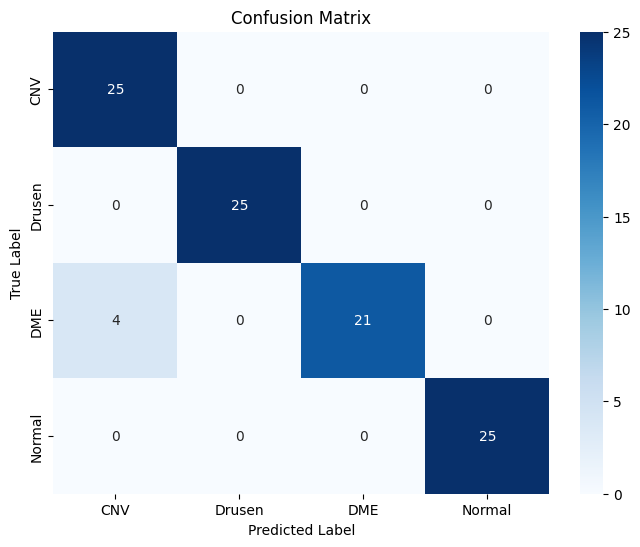

In [13]:
evaluator.evaluate(test_loader)

In [15]:
import torch

# Save the trained model
model_save_path = "swin_transformer_mini_model.pth"
torch.save(trainer.model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to swin_transformer_mini_model.pth


In [17]:
import torch
from transformers import SwinForImageClassification
from torchvision import transforms
from PIL import Image

# Load the model
model = SwinForImageClassification.from_pretrained('microsoft/swin-tiny-patch4-window7-224')
model.classifier = nn.Linear(model.classifier.in_features, 4)  # Replace 4 with the number of classes if necessary
model.load_state_dict(torch.load("swin_transformer_model.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()  # Set to evaluation mode

# Move model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing for a single image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to classify an image
def classify_image(image_path):
    # Open and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor).logits
        _, predicted = torch.max(output, 1)

    # Map predicted class index to class name
    class_names = ['CNV', 'DME', 'Drusen', 'Normal']  # Adjust based on your class names
    predicted_class = class_names[predicted.item()]
    return predicted_class



<ipython-input-17-e376671221a4>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("swin_transformer_model.pth", map_location=torch.device('cu

In [18]:
# Example usage
image_path = "/content/drive/MyDrive/Projects/HDA Proj/test/NORMAL/NORMAL-12494-2.jpeg"  # Replace with the path to your image
predicted_class = classify_image(image_path)
print(f"Predicted class: {predicted_class}")

Predicted class: Normal
